# Import dependencies

In [100]:
import cleverhans
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.attacks import FastGradientMethod
from cleverhans.model import Model as CleverhansModel
from io import BytesIO
import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image
import requests
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

In [101]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Define model wrapper for cleverhans

In [102]:
class InceptionV1Model(CleverhansModel):
    SCOPE = 'inceptionv1'
    SOFTMAX_OP = 'softmax2'
  
    def __init__(self):
        super(InceptionV1Model, self).__init__()
        self._model = models.InceptionV1()
        self._model.load_graphdef()
        self._fprop_cache = dict()

    def fprop(self, x):
        if x not in self._fprop_cache:
            # https://github.com/tensorflow/lucid/blob/67e19f38c315e548034c3e4315dfee6f718df916/lucid/modelzoo/vision_base.py#L189
            graph = x.graph
            scope = graph.unique_name(
              '%sfprop%d' % (self.SCOPE, len(self._fprop_cache)), False)
            _, x_prep = self._model.create_input(x, forget_xy_shape=True)
            final_input_map = {self._model.input_name: x_prep}
            ops = tf.import_graph_def(self._model.graph_def, final_input_map,
                                    return_elements=[self.SOFTMAX_OP], name=scope)
            self._model.post_import(scope)

            softmax2_op = ops[0]
            logits = softmax2_op.inputs[0]
            logits = logits[:, :1000]

            self._fprop_cache[x] = {'logits' : logits}

        return self._fprop_cache[x]

# Define utility functions

In [4]:
def load_image_from_url(img_url, resize_to=(224, 224)):
    img_response = requests.get(img_url)
    img = Image.open(BytesIO(img_response.content))
    if resize_to is not None:
        img = img.resize(resize_to)
    img = np.array(img)
    return img

In [5]:
def load_image_from_file(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [6]:
def get_predictions(model, imgs):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:  
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))
        y = model.get_probs(x)
        y = tf.arg_max(y, 1)
        y_eval = sess.run(y, feed_dict={x: imgs})

    return y_eval

In [141]:
def attack_images(model, imgs, attack_type="FGM", attack_kwargs={'eps': 0.3}):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))

        if attack_type == "FGM":
            attack = FastGradientMethod(model, sess=sess)
        elif attack_type == "PGD":
            attack = ProjectedGradientDescent(model, sess=sess)
        
        adv_imgs = attack.generate(x, **attack_kwargs)
        adv_imgs_eval = sess.run(adv_imgs, feed_dict={x: imgs})

    return adv_imgs_eval

# Initialize model and load image

In [107]:
model = InceptionV1Model()

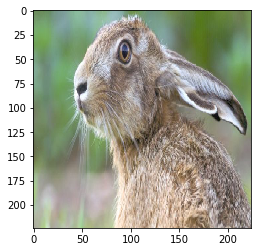

In [153]:
# Get an input image from url

# White wolf
# img_url = ('https://images.fineartamerica.com/images/artworkimages'
#            '/mediumlarge/1/white-wolf-elaine-mikkelstrup.jpg')

# Koala
# img_url = ('https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg')

# Ibex1
# img_url = ('https://cdn.britannica.com/36/122936-004-3C9BCCDA/Pyrenean-Spanish-ibex.jpg')

# Ibex2
# img_url = ('https://i.redd.it/tpy0jw7a0mz21.jpg')

# Panda
# img_url = ('https://cbsnews1.cbsistatic.com/hub/i/2016/08/26/cdf56aa8-1f2a-4d44-8cac-ab5993ee7d18/gettyimages-594359398.jpg')

# # Panda2
# img_url = ('https://scx1.b-cdn.net/csz/news/800/2019/giantpandame.jpg')

# # Panda3 
# img_url = ('https://media.treehugger.com/assets/images/2017/03/giantpanda.jpg.860x0_q70_crop-scale.jpg')

# gazelle
img_url = ('https://cdn.dmnews.com/files/base/acbm/dmn/image/2015/07/960w/gazellejumping_800911.jpg')

# saluki
img_url = ('https://dogsaholic.com/wp-content/uploads/2016/07/Saluki-dog-breed.jpg')

# hare
img_url = ('https://i.dailymail.co.uk/1s/2018/10/13/22/5026688-6273281-image-m-27_1539466157164.jpg')

# hare2
img_url = ('https://ichef.bbci.co.uk/news/660/cpsprodpb/DA33/production/_103795855_brownharegraememayesjpegnew.jpg')

img = load_image_from_url(img_url)
plt.imshow(img)
plt.show()

# Experiments

## Get prediction on benign image

In [154]:
# 102 -> white_wolf
# 9 -> Ibex
# 213 -> Koala
# 169 -> giant_panda
# 129 -> hare
# 178 -> armadillo
get_predictions(model, [img]) 

array([129])

## Generate attacked image

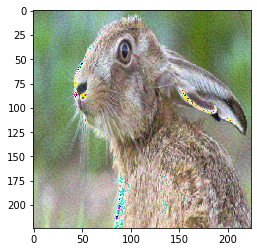

In [155]:
adv_imgs = attack_images(model, [img], attack_type="FGM", attack_kwargs={'eps': 9})
adv_img = adv_imgs[0]
plt.imshow(np.array(adv_img, dtype=np.uint8))

## Get prediction on adversarial image

In [156]:
get_predictions(model, [adv_img])

array([912])

In [157]:
import pandas as pd
label_df = pd.read_csv('../data/imagenet_tfrecords_labels.txt', sep=' ', names=['syn', 'label', 'name'])
label_dict = {int(label): name for label, name in zip(label_df['label'], label_df['name'])}

## Generate many adversarial images with different strength

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


wood_rabbit(188), eps: 1


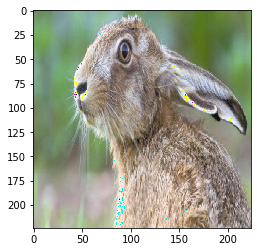

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


wood_rabbit(188), eps: 5


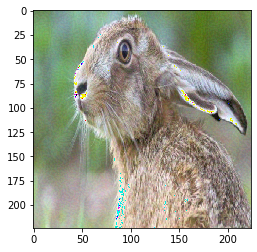

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


window_screen(912), eps: 10


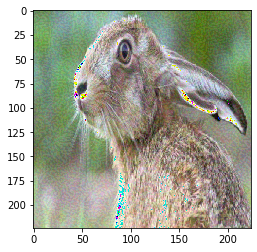

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


window_screen(912), eps: 20


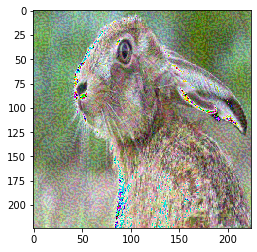

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


window_screen(912), eps: 30


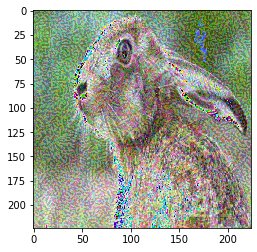

/Users/haekyu/anaconda3/envs/massif/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:405: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "


window_screen(912), eps: 50


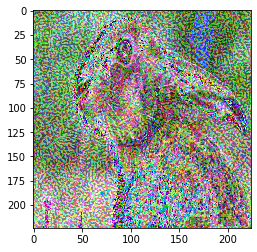

In [158]:
eps_list = [1, 5, 10, 20, 30, 50]
num_rows = len(eps_list)
num_cols = 2

for i, eps in enumerate(eps_list):
    adv_imgs = attack_images(model, [img], attack_kwargs={'eps': eps, 'eps_iter': 1.0, 'nb_iter': 20})
    adv_img = adv_imgs[0]
    predicted_class = get_predictions(model, [adv_img])[0]
    predicted_class_name = label_dict[predicted_class]
    
    print('{}({}), eps: {}'.format(predicted_class_name, predicted_class, eps))
    plt.figure()
    
    # Attacked image
    attacked_img = np.array(adv_img, dtype=np.uint8)
    plt.imshow(attacked_img)
    plt.show()
    
    # Save the attacked image
    filename = '../data/sample-images/attacked-hare-{}-{}-{}'.format(predicted_class_name, predicted_class, eps)
    np.save(filename, adv_img)

In [86]:
predicted_class = 178
armadillo = np.load('../data/sample-images/attacked-hare-{}-{}-{}.npy'.format('armadillo', predicted_class, 5))
print(predicted_class, get_predictions(model, [recheck]))

178 [178]


In [99]:
import imageio
save_filename = '../data/sample-images/attacked-hare-{}-{}-{}.png'.format('armadillo', predicted_class, 5)
imageio.imwrite(save_filename, np.array(armadillo, dtype=np.uint8), format=None)